In [1]:
import tensorflow as tf
import pathlib
import PIL
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.python.module.module import valid_identifier
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
import splitfolders

2023-02-07 09:32:40.552919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
splitfolders.ratio('./finalProject#2/final_dataset#2', output="./finalProject#2/split_dataset", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 7597 files [00:50, 151.37 files/s]


In [2]:
train_path = "./finalProject#2/split_dataset/train"
test_path = "./finalProject#2/split_dataset/test"
val_path = "./finalProject#2/split_dataset/val"

In [3]:
batch_size = 32
img_height = 224
img_width = 224

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 6346 files belonging to 5 classes.


2023-01-22 19:33:09.966069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 920 files belonging to 5 classes.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 1130 files belonging to 5 classes.


['BarniP2_1', 'KhalasP2_1', 'Khenezi solo', 'Segai', 'mixed']


2023-01-17 17:20:28.412524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 238 of 256
2023-01-17 17:20:29.074183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


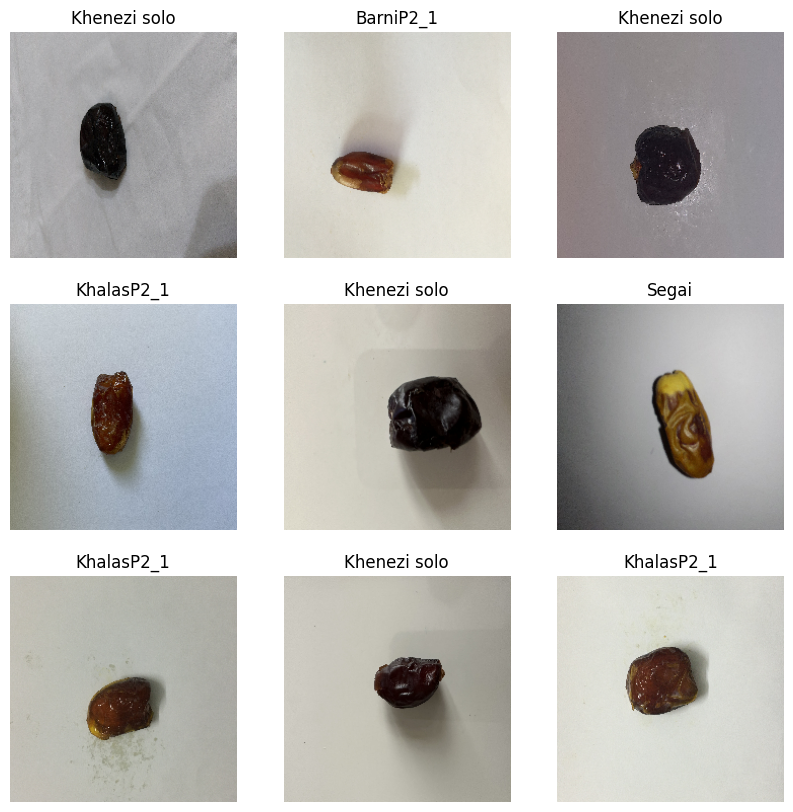

In [8]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
  tf.keras.layers.RandomRotation(0.2),
  ]
)

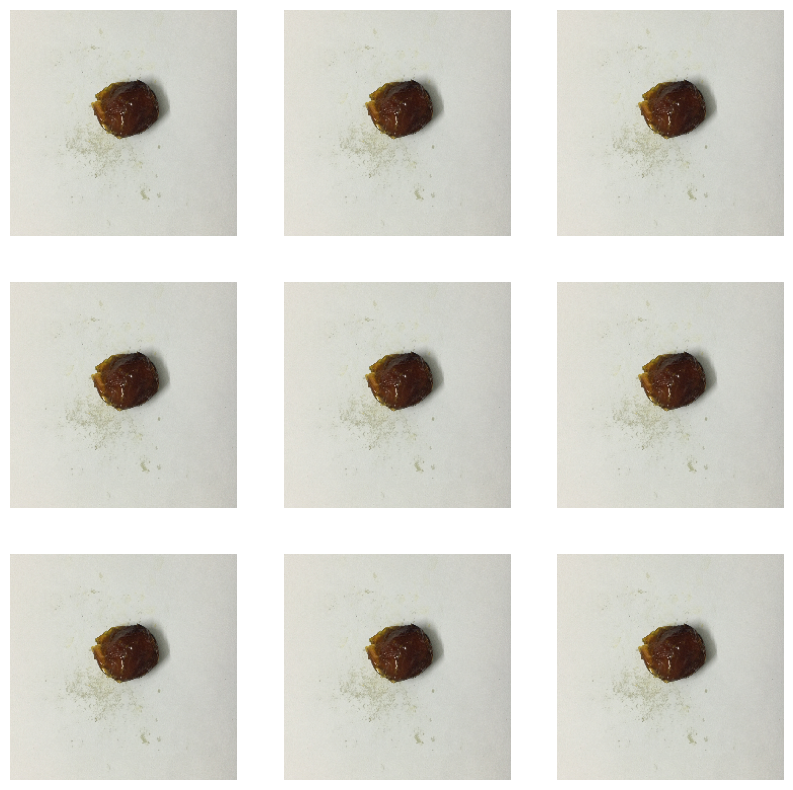

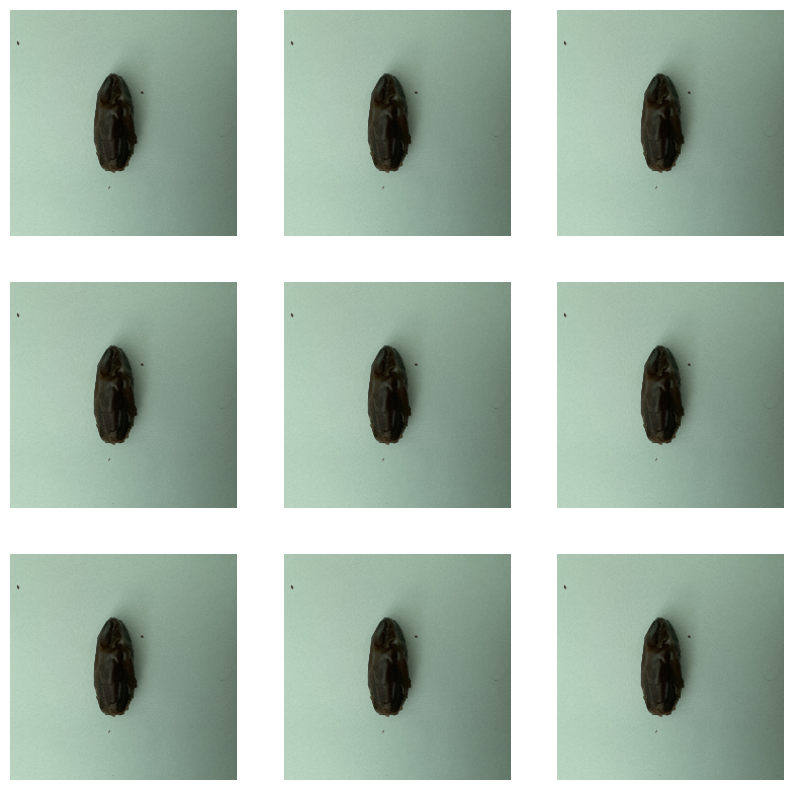

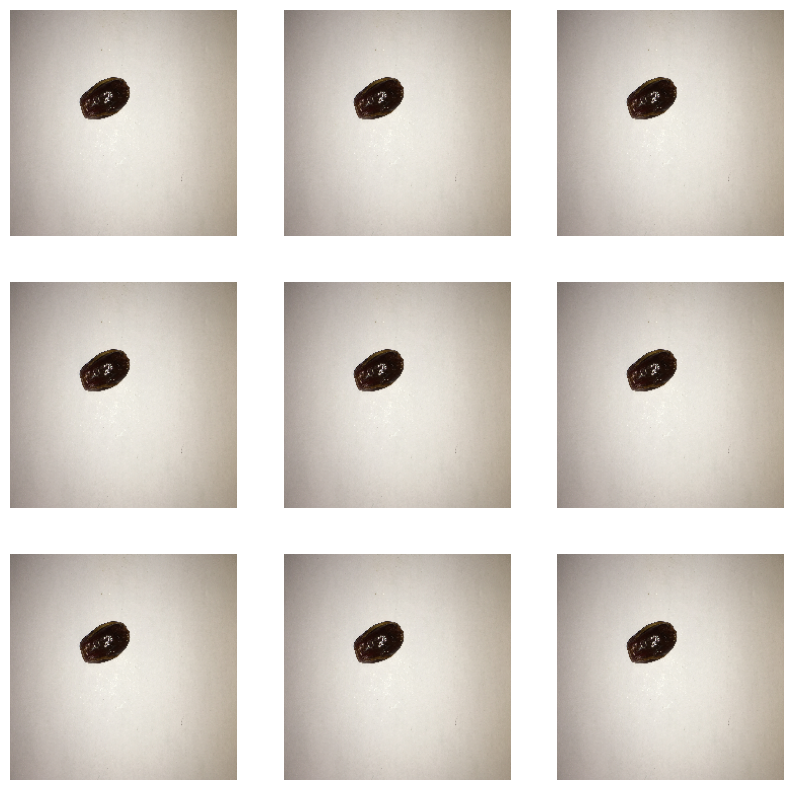

In [146]:
for image, _ in train_ds.take(3):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_height, img_width) + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [14]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-01-17 17:21:15.823011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 246 of 256
2023-01-17 17:21:15.823037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-01-17 17:21:17.448353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-01-17 17:21:25.839171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7 of 1000
2023-01-17 17:21:36.646262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 15 of 1000
2023-01-17 17:21:45.659247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 22 of 1000
2023-01-17 17:21:56.293753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 30 of 1000
2023-

(32, 7, 7, 960)


In [15]:
base_model.trainable = False

In [16]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 960)


In [18]:
prediction_layer = tf.keras.layers.Dense(5,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [19]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 5)                 4805  

In [22]:
num_classes = len(class_names)
print(num_classes)
# model = Sequential([
#   data_augmentation,
#   hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5", trainable=False),
#   tf.keras.layers.GlobalAveragePooling2D(),
#   tf.keras.layers.Dense(num_classes)
# ])

# model.build([None, 224, 224, 3])  # Batch input shape.

5


In [23]:
len(model.trainable_variables)

2

In [24]:
initial_epochs = 130

loss0, accuracy0 = model.evaluate(val_ds)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-01-17 17:27:24.786682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 222 of 256
2023-01-17 17:27:26.383964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


29/29 [==============================] - 56s 1s/step - loss: 1.7881 - accuracy: 0.2250


In [25]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/130
199/199 [==============================] - 159s 773ms/step - loss: 1.4047 - accuracy: 0.4504 - val_loss: 1.0202 - val_accuracy: 0.6228
Epoch 2/130
199/199 [==============================] - 155s 779ms/step - loss: 0.9448 - accuracy: 0.6499 - val_loss: 0.7746 - val_accuracy: 0.7315
Epoch 3/130
199/199 [==============================] - 144s 723ms/step - loss: 0.7506 - accuracy: 0.7165 - val_loss: 0.6495 - val_accuracy: 0.7728
Epoch 4/130
199/199 [==============================] - 144s 725ms/step - loss: 0.6351 - accuracy: 0.7669 - val_loss: 0.5878 - val_accuracy: 0.7837
Epoch 5/130
199/199 [==============================] - 143s 718ms/step - loss: 0.5458 - accuracy: 0.8024 - val_loss: 0.5178 - val_accuracy: 0.8152
Epoch 6/130
199/199 [==============================] - 143s 718ms/step - loss: 0.4989 - accuracy: 0.8125 - val_loss: 0.4869 - val_accuracy: 0.8141
Epoch 7/130
199/199 [==============================] - 142s 713ms/step - loss: 0.4492 - accuracy: 0.8429 - val_loss: 0

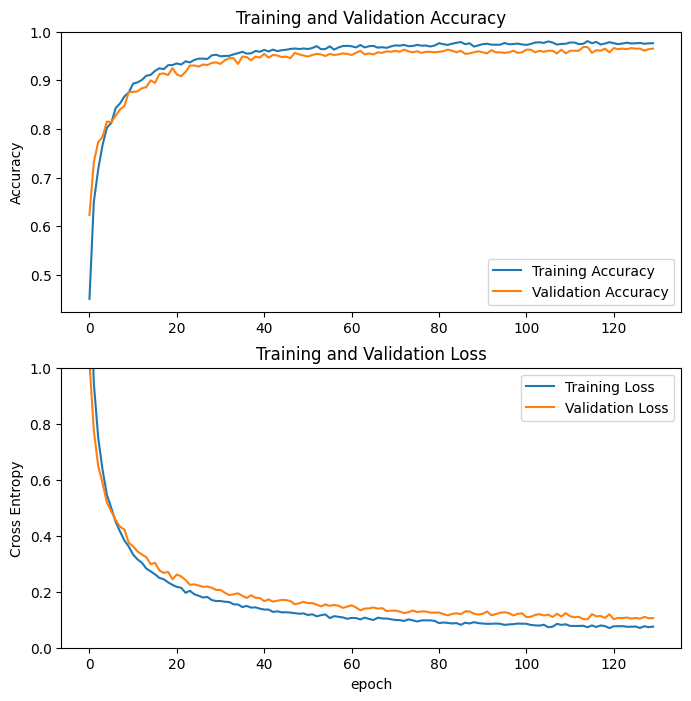

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [45]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

36/36 [==============================] - 54s 1s/step - loss: 0.0328 - accuracy: 0.9885
Test accuracy : 0.9884955883026123


In [66]:
from cProfile import label
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, roc_curve



y_pred=model.predict(test_ds)
y_pred=np.argmax(y_pred,axis=1)
print(y_pred)

36/36 [==============================] - 54s 1s/step
[0 0 0 ... 4 4 4]


In [49]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
print(true_categories)

tf.Tensor([0 0 0 ... 4 4 4], shape=(1130,), dtype=int32)


In [50]:
print(confusion_matrix(true_categories,y_pred))

[[410   6   2   0   0]
 [  1 160   0   0   0]
 [  0   0 196   0   0]
 [  0   0   0 247   1]
 [  0   0   1   2 104]]


<AxesSubplot: >

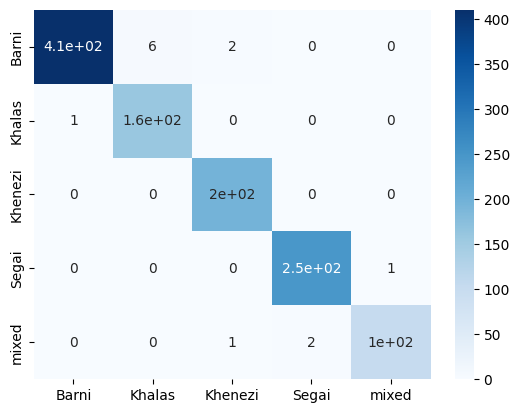

In [51]:
import seaborn as sns
sns.heatmap(confusion_matrix(true_categories,y_pred), annot=True,xticklabels=['Barni', 'Khalas', 'Khenezi', 'Segai', 'mixed'], yticklabels=['Barni', 'Khalas', 'Khenezi', 'Segai', 'mixed'], cmap="Blues")


In [52]:
print(classification_report(true_categories,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       418
           1       0.96      0.99      0.98       161
           2       0.98      1.00      0.99       196
           3       0.99      1.00      0.99       248
           4       0.99      0.97      0.98       107

    accuracy                           0.99      1130
   macro avg       0.99      0.99      0.99      1130
weighted avg       0.99      0.99      0.99      1130



In [53]:
model.save("./saveModelWith_transfer_2.h5", save_format='h5')

In [55]:
# Load the h5 model
model = tf.keras.models.load_model('./saveModelWith_transfer_2.h5')

# Convert to TensorFlow SavedModel
tf.saved_model.save(model, 'saved_model')

# Convert the SavedModel to tflite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()
open("modelnew.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets
2023-01-18 20:05:01.212461: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-01-18 20:05:01.212979: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-01-18 20:05:01.236854: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: saved_model
2023-01-18 20:05:01.307890: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-01-18 20:05:01.308777: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: saved_model
2023-01-18 20:05:01.478133: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-01-18 20:05:01.523488: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-01-18 20:05:02.304991: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedMo

11921304